# Stops, places and moves location analysis

Definitions:
- **Location data** is collected as a sequence of location samples with varying
sample frequency and accuracy.
- **Places** are locations of relevance to the user, such as home or workplace and
are described by their coordinates and an ID.
- **Stops** are specific visits to one of those places, described by their
coordinates along with arrival and departure time. A stop is always associated
with exactly one place while a place can be associated with many stops. Stops
are always non-overlapping in time.
- **Moves** are sequences of location points between stops and are described by
departure and arrival time, origin and destination place and the distance of
the move.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn.cluster import DBSCAN
import gmaps

import sys
sys.path.append("../")
from location import *

# Keep data consistent, load from disk.
LOAD_DATA_FROM_DISK = False

In [2]:
def get_date(row):
    return row.date()

## Generate example data

In [3]:
if LOAD_DATA_FROM_DISK:
    df = pd.read_json('multi_date_data.json').T
    df.datetime = pd.to_datetime(df.datetime, unit='ms')
    df.date = df.datetime.dt.date.astype('datetime64[ns]')
else:
    # create data simulating 3 places (a,b,c)
    a = (55.686381, 12.557155) # Blaagaards Plads
    b = (55.666919, 12.536792) # Spaces
    c = (55.688305, 12.561862) # Hulen

    X = np.vstack([
        # day 1: home, work, home, workout, home
        np.array([a]*(60*8+30)),
        np.array([np.linspace(a[0], b[0], 30), np.linspace(a[1], b[1], 30)]).T,
        np.array([b]*(60*7+30)),
        np.array([np.linspace(b[0], a[0], 30), np.linspace(b[1], a[1], 30)]).T,
        np.array([a]*55),
        np.array([np.linspace(a[0], c[0], 5), np.linspace(a[1], c[1], 5)]).T,
        np.array([c]*55),
        np.array([np.linspace(c[0], a[0], 5), np.linspace(c[1], a[1], 5)]).T,
        np.array([a]*60*5),
        # day 2: home, work, home
        np.array([a]*(60*8+30)),
        np.array([np.linspace(a[0], b[0], 30), np.linspace(a[1], b[1], 30)]).T,
        np.array([b]*(60*7+30)),
        np.array([np.linspace(b[0], a[0], 30), np.linspace(b[1], a[1], 30)]).T,
        np.array([a]*60*7),
        # day 3: home, workout, home
        np.array([a]*(60*10+55)),
        np.array([np.linspace(a[0], c[0], 5), np.linspace(a[1], c[1], 5)]).T,
        np.array([c]*55),
        np.array([np.linspace(c[0], a[0], 5), np.linspace(c[1], a[1], 5)]).T,
        np.array([a]*60*12),
        ])
    
    X += np.random.normal(loc=0, scale=0.00005, size=X.shape)
    
    df = pd.DataFrame(X, columns=['latitude', 'longitude'])
    df.insert(0, 'user_id', 0)
    df.insert(1, 'timestamp', np.arange(df.shape[0]) * 60000 + 1573430400000.0)
    df.insert(2, 'datetime', pd.to_datetime(df.timestamp, unit='ms'))
    df.insert(3, 'date', df.datetime.dt.date.astype('datetime64[ns]'))
    
    # Write to file
    df.T.to_json('multi_date_data.json')
    
df.head()

df.date = df.date.apply(get_date)

In [57]:
dates = np.unique(df.date.values)
dates

array([datetime.date(2019, 11, 11), datetime.date(2019, 11, 12),
       datetime.date(2019, 11, 13)], dtype=object)

## Quick visualization of the 3 places visited

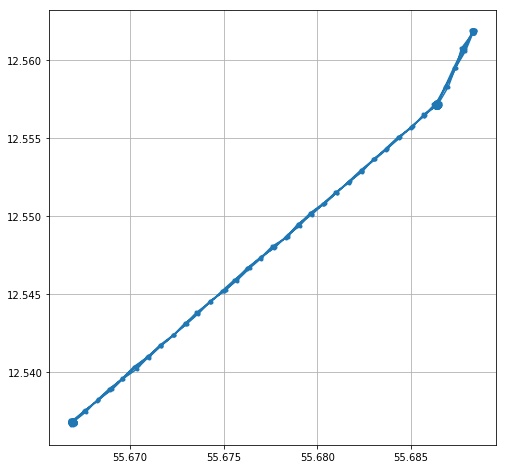

In [58]:
plt.figure(figsize=(8,8))
plt.plot(df.latitude.values, df.longitude.values, marker='.', alpha=1)
plt.grid()
plt.show()

## Preprocessing (stops, places and moves)

* A `stop` is a collection of stationary points
* A `place` is a cluster of `stops` found using DBSCAN
* A `move` is a transition from one `stop` to another.

In [6]:
stops, places, moves = get_stops_places_and_moves(df)
stops['date'] = stops.arrival.apply(get_date)
moves['date'] = moves.arrival.apply(get_date)

In [7]:
stops

,user_id,latitude,longitude,samples,arrival,departure,duration,place,date
0,0,55.686381,12.557161,511,2019-11-11 00:00:00,2019-11-11 08:30:00,510.0,0,2019-11-11
1,0,55.666914,12.536788,452,2019-11-11 08:59:00,2019-11-11 16:30:00,451.0,1,2019-11-11
2,0,55.686383,12.557170,57,2019-11-11 16:59:00,2019-11-11 17:55:00,56.0,0,2019-11-11
3,0,55.688303,12.561877,57,2019-11-11 17:59:00,2019-11-11 18:55:00,56.0,2,2019-11-11
4,0,55.686376,12.557154,812,2019-11-11 18:59:00,2019-11-12 08:30:00,811.0,0,2019-11-11
5,0,55.666921,12.536791,452,2019-11-12 08:59:00,2019-11-12 16:30:00,451.0,1,2019-11-12
6,0,55.686382,12.557154,1077,2019-11-12 16:59:00,2019-11-13 10:55:00,1076.0,0,2019-11-12
7,0,55.688310,12.561865,57,2019-11-13 10:59:00,2019-11-13 11:55:00,56.0,2,2019-11-13
8,0,55.686377,12.557154,721,2019-11-13 11:59:00,2019-11-13 23:59:00,720.0,0,2019-11-13


In [8]:
places

,user_id,place,latitude,longitude,duration,stops
0,0,0,55.686381,12.557154,3173.0,5
1,0,1,55.666918,12.536790,902.0,2
2,0,2,55.688307,12.561871,112.0,2


In [9]:
moves

,user_id,from_latitude,from_longitude,to_latitude,to_longitude,samples,departure,arrival,from_place,to_place,distance,duration,mean_speed,date
0,0,55.686350,12.557288,55.666931,12.536812,30,2019-11-11 08:30:00,2019-11-11 08:59:00,0.0,1.0,2520.430627,29.0,1.448523,2019-11-11
1,0,55.666994,12.536835,55.686413,12.557147,30,2019-11-11 16:30:00,2019-11-11 16:59:00,1.0,0.0,2516.562350,29.0,1.446300,2019-11-11
2,0,55.686326,12.557210,55.666843,12.536827,30,2019-11-12 08:30:00,2019-11-12 08:59:00,0.0,1.0,2523.909200,29.0,1.450523,2019-11-12
3,0,55.666941,12.536796,55.686385,12.557099,30,2019-11-12 16:30:00,2019-11-12 16:59:00,1.0,0.0,2518.612156,29.0,1.447478,2019-11-12


### Visualizing the clusters and moves

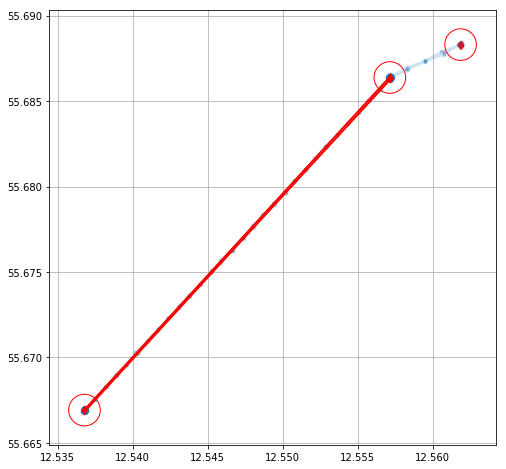

In [59]:
plt.figure(figsize=(8,8))
plt.plot(df.longitude.values, df.latitude.values, marker='.', alpha=.2)
plt.scatter(stops.longitude.values, stops.latitude.values, marker='d', color='r', zorder=10, alpha=.5)
plt.scatter(places.longitude.values, places.latitude.values, s=1000, facecolors='none', edgecolors='r')
for index, move in moves.iterrows():
    plt.plot([move.from_longitude, move.to_longitude], [move.from_latitude, move.to_latitude], color='r')
plt.grid()
plt.show()

# Features

## Number of clusters 
This feature represents the total number of clusters found by the clustering algorithm.

In [60]:
def number_of_clusters(places):
    return len(places)

In [61]:
number_of_clusters(places)

3

## Location Variance: 
This feature measures the variability of a participant’s location data from stationary states. LV was computed as the natural logarithm of the sum of the statistical variances of the latitude and the longitude components of the location data.

In [62]:
def location_variance(df):
    # If fewer than 2 observations, we can't compute the variance
    if len(df) < 2:
        return 0.0
    return np.log(df.latitude.var() + df.longitude.var() + 1)

In [63]:
location_variance(df)

0.00013597465949774686

## Location Entropy (LE): 
_A measure of points of interest. High entropy indicates that the participant spent time more uniformly across different location clusters, while lower entropy indicates the participant spent most of the time at some specific clusters. Concretely it is calculated as:_

$$Entropy = - \sum_{i=1}^N p_i \cdot \log p_i$$

_where each i represents a location cluster, N denotes the total number of location clusters, and pi is the percentage of time the participant spent at the location cluster i. High cluster entropy indicates that the participant spent time more uniformly across different location clusters, while lower cluster entropy indicates the participant spent most of the time at some specific clusters._

Here, we use the duration spent at each place, found in the `duration` column in the `places` dataframe.

In [64]:
def _entropy(durations):
    p = durations / np.sum(durations)
    return -np.sum(p * np.log(p))

In [65]:
_entropy(places.duration)

0.6377255748619863

In [66]:
# NumPy for reference:

from scipy.stats import entropy
entropy(places.duration)

0.6377255748619863

## Normalized LE: 
_Normalized entropy is calculated by dividing the cluster entropy by its maximum value, which is the logarithm of the total number of clusters. Normalized entropy is invariant to the number of clusters and thus solely depends on their visiting distribution. The value of normalized entropy ranges from 0 to 1, where 0 indicates the participant has spent their time at only one location, and 1 indicates that the participant has spent an equal amount of time to visit each location cluster._

Here we just divide by the log to the number of places.

In [67]:
def normalized_entropy(durations):
    return entropy(durations) / np.log(len(durations))

In [68]:
normalized_entropy(places.duration)

0.5804828340625297

## Transition Time: 
_Transition Time measures the percentage of time the participant has been in the transition state._

A few ways of doing this, but one is using the `moves` dataframe and simply summing the `duration` column, and dividing by 24 hours.

In [69]:
def transition_time(moves):
    move_time = moves.duration.sum()
    return move_time / (24 * 60)

In [70]:
transition_time(moves)

0.08055555555555556

# Total Distance: 
_This feature measures the total distance the participant has traveled in the transition state._

Here we simply sum the `distance` column in the `moves` dataframe.

In [71]:
def total_distance(moves):
    return moves.distance.sum()

In [72]:
total_distance(moves)

10079.514332342535

## Routine Index

In [73]:
HOURS_IN_A_DAY = 24

def print_hour_matrix(M):
    for i, row in enumerate(M):
        line = "[{:0>2} - {:0>2}] ".format(i, i+1)
        for e in row:
            line += '%0.2f ' % e
        print(line)

def make_hour_matrix(stops, num_places):
    h = np.zeros((HOURS_IN_A_DAY, num_places))
    
    for index, row in stops.iterrows():
        pid = row.place
        start_hour = row.arrival.hour
        end_hour   = row.departure.hour
        
        # If user arrived and departed within the same hour
        # Then the time stayed is the diff between departure and arrival
        if start_hour == end_hour:
            h[start_hour, pid] = row.departure.minute - row.arrival.minute
        
        else:
            # Arrival hour
            h[start_hour, pid] = 60 - row.arrival.minute

            # In between
            for hour in range(start_hour+1, end_hour):
                h[hour, pid] = 60

            # Departure hour
            h[end_hour, pid] = row.departure.minute
        
    return h / 60 # Normalize by 60 mins

In [74]:
# Plot a matrix as a color map
def matrix_plot(m):
    plt.figure(figsize=(10,10))
    plt.imshow(m, cmap='bone')
    plt.title('Hour matrix')
    plt.xlabel('Place ID')
    plt.ylabel('Timeslot')
    plt.yticks(range(HOURS_IN_A_DAY), ["[{:0>2} - {:0>2}] ".format(i, i+1) for i in range(HOURS_IN_A_DAY)])
    plt.xticks(range(m.shape[1]))
    plt.show()

In [75]:
s1 = stops[stops.date == dates[0]]
s1

,user_id,latitude,longitude,samples,arrival,departure,duration,place,date
0,0,55.686381,12.557161,511,2019-11-11 00:00:00,2019-11-11 08:30:00,510.0,0,2019-11-11
1,0,55.666914,12.536788,452,2019-11-11 08:59:00,2019-11-11 16:30:00,451.0,1,2019-11-11
2,0,55.686383,12.557170,57,2019-11-11 16:59:00,2019-11-11 17:55:00,56.0,0,2019-11-11
3,0,55.688303,12.561877,57,2019-11-11 17:59:00,2019-11-11 18:55:00,56.0,2,2019-11-11
4,0,55.686376,12.557154,812,2019-11-11 18:59:00,2019-11-12 08:30:00,811.0,0,2019-11-11


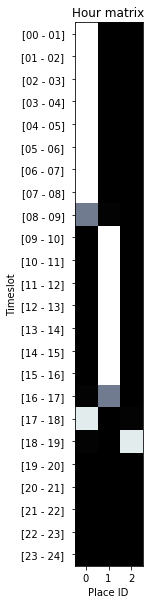

In [76]:
h1 = make_hour_matrix(s1, len(places))
matrix_plot(h1)

In [77]:
def RI(h_mean, h, end_hour=24):
    '''
    input:
        h_mean (2d matrix): Historical Mean Matrix
        h (2d matrix): Hour Matrix for a day
    
    output:
        routine_index: -1 (could not be calculated) or [0 to 1]. 
    '''
    if h_mean.sum() == 0:
        return -1.0 # no routine index could be calculated
    
    assert(h_mean.shape == h.shape)
    
    m,n = h.shape
    
    overlap = 0.0
    for i in range(m):
        for j in range(n):
            overlap += min(h_mean[i,j], h[i,j])
            
    max_overlap = min(h_mean.sum(), h.sum())
    
    return overlap / max_overlap

## Using todays stops and historical stops to calculate routine index
I.e. no updating of routine matrix, always recalculate it.

In [78]:
STOPS = {}
for date in dates:
    print('Date:', date)
    # Select data by date
    data = df[df.date == date]
    
    # Find stops, moves, places
    S, P, M = get_stops_places_and_moves_daily(data, merge=False, move_duration=3)
    
    # Store them
    STOPS[date] = S

Date: 2019-11-11
Date: 2019-11-12
Date: 2019-11-13


In [79]:
def plot_today_and_routine(today, routine, routine_after, save=False):
    interval_strings = ["[{:0>2} - {:0>2}] ".format(i, i+1) for i in range(HOURS_IN_A_DAY)]
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_size_inches((10,10))

    
    ax1.imshow(routine, cmap='bone')
    ax1.set_title('Routine')
    ax1.set_xlabel('Place ID')
    ax1.set_ylabel('Timeslot')
    ax1.set_yticks(range(HOURS_IN_A_DAY))
    ax1.set_yticklabels(interval_strings)
    ax1.set_xticks(range(routine.shape[1]))
    
    ax2.imshow(today, cmap='bone')
    ax2.set_title('Today')
    ax2.set_xlabel('Place ID')
    ax2.set_ylabel('Timeslot')
    ax2.set_yticks(range(HOURS_IN_A_DAY))
    ax2.set_yticklabels(interval_strings)
    ax2.set_xticks(range(today.shape[1]))
    
    ax3.imshow(routine_after, cmap='bone')
    ax3.set_title('Updated Routine')
    ax3.set_xlabel('Place ID')
    ax3.set_ylabel('Timeslot')
    ax3.set_yticks(range(HOURS_IN_A_DAY))
    ax3.set_yticklabels(interval_strings)
    ax3.set_xticks(range(routine_after.shape[1]))
    
    if save:
        plt.savefig('routine.png')
    plt.show()

In [80]:
DISTF = lambda a, b: geodesic(a, b).meters

def get_places_2(stops, dist=25, distf=DISTF):
    if stops.empty:
        stops['place'] = []
        places = pd.DataFrame(columns=['user_id', 'place', 'latitude', 'longitude', 'duration', 'stops'])
    else:
        points = stops[['latitude', 'longitude']].values
        dbs = DBSCAN(dist, min_samples=1, metric=distf).fit(points)
        stops['place'] = dbs.labels_
        places = stops.groupby('place').agg({
            'latitude': np.median,
            'longitude': np.median,
            'duration': np.sum,
            'samples': len,
        }).reset_index()
        places.rename(columns={'samples': 'stops'}, inplace=True)
        places.insert(0, 'user_id', stops.user_id.values[0])
    return stops, places

Routine index: -1.00
-----------------------------------
2019-11-12


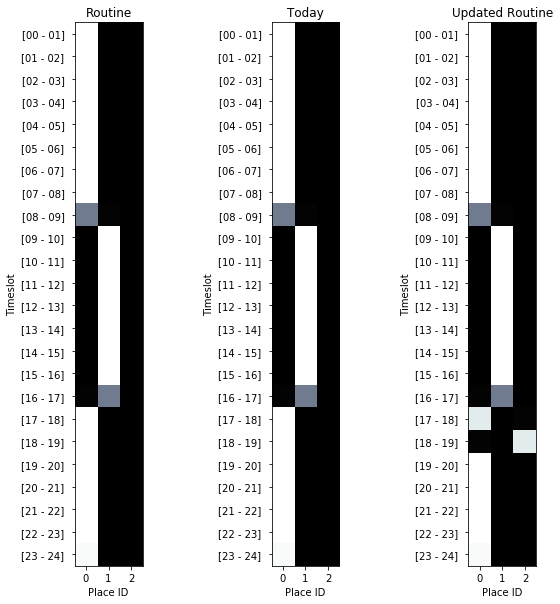

Routine index: 0.96
-----------------------------------
2019-11-13


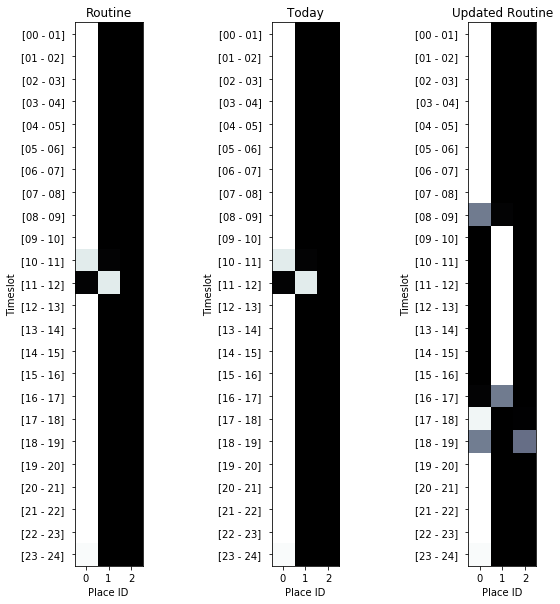

Routine index: 0.69
-----------------------------------


In [96]:
for date in dates:
    # Calculate todays matrix
    stops_today = STOPS[date]
    stops_so_far = [STOPS[d] for d in dates[dates <= date]]
    stops_so_far = pd.concat(stops_so_far)
    stops_so_far = stops_so_far.sort_values(['arrival'])
    stops_so_far = stops_so_far.reset_index()
    stops_so_far, places_so_far = get_places_2(stops_so_far)
    
    number_of_places = len(places_so_far)
    
    hour_matrix_today = make_hour_matrix(stops_today, number_of_places)
    
    dates_hist = dates[dates < date]
    
    routine_matrix = hour_matrix_today
    
    if len(dates_hist) > 0:
        print(date)
        hour_matrices_hist = [make_hour_matrix(STOPS[date_hist], number_of_places) for date_hist in dates_hist]
        new_routine_matrix = np.mean(hour_matrices_hist, axis=0)
        ri = RI(new_routine_matrix, hour_matrix_today)
        plot_today_and_routine(hour_matrix_today, routine_matrix, new_routine_matrix)
        routine_matrix = new_routine_matrix
        
    else:
        ri = -1
    print('Routine index: %0.2f' % ri)

    hms[date] = hour_matrix_today
    rms[date] = routine_matrix
    
    print('-'*35)

## Home Stay: 
_The percentage of time the participant has been at the cluster that represents home. We define the home cluster as the cluster, which is mostly visited during the period between 12 am and 6 am._

Implementation steps:
* Identify home: Use the `hours` dataframe to determine the most visited cluster between 00 and 06 am.
* Count percentage of time at home: Use the `places` dataframe to calculate the time distribution. 

__However - we need to fill out the `hours` dataframe with data between 00 and 06 first__

In [33]:
date = dates[0]
# Calculate todays matrix
stops_today = STOPS[date]
stops_so_far = [STOPS[d] for d in dates[dates <= date]]
stops_so_far = pd.concat(stops_so_far)
stops_so_far = stops_so_far.sort_values(['arrival'])
stops_so_far = stops_so_far.reset_index()
stops_so_far, places_so_far = get_places_2(stops_so_far)

num_places = len(places_so_far)

In [34]:
H = make_hour_matrix(stops_today, num_places)

In [104]:
def get_home_place(hour_matrix):
    start, end = 0, 6
    place_dist = hour_matrix[start:end].sum()
    
    # Check that there was actually data between 00 and 06
    assert not np.all(hour_matrix[start:end].sum() == 0)
    
    return hour_matrix[start:end].sum().argmax()

def home_stay(places, hour_matrix):
    distr = places.duration / places.duration.sum()
    home_id = get_home_place(hour_matrix)
    return distr[home_id]

In [106]:
get_home_place(H)

0

In [109]:
home_stay(places_so_far, H)

0.6307356154406409